# **VGG_19**

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 214MB/s] 


Epoch [1/50] Train Loss: 1.7616 Train Acc: 0.3509 Val Loss: 1.4339 Val Acc: 0.4792
Epoch [2/50] Train Loss: 0.9203 Train Acc: 0.7176 Val Loss: 1.3390 Val Acc: 0.5046
Epoch [3/50] Train Loss: 0.5681 Train Acc: 0.8710 Val Loss: 1.2548 Val Acc: 0.5417
Epoch [4/50] Train Loss: 0.3742 Train Acc: 0.9424 Val Loss: 1.1617 Val Acc: 0.5995
Epoch [5/50] Train Loss: 0.2334 Train Acc: 0.9762 Val Loss: 1.1593 Val Acc: 0.5903
Epoch [6/50] Train Loss: 0.1632 Train Acc: 0.9866 Val Loss: 1.1407 Val Acc: 0.5926
Epoch [7/50] Train Loss: 0.1178 Train Acc: 0.9955 Val Loss: 1.1240 Val Acc: 0.5972
Epoch [8/50] Train Loss: 0.1040 Train Acc: 0.9975 Val Loss: 1.1097 Val Acc: 0.6065
Epoch [9/50] Train Loss: 0.0911 Train Acc: 0.9980 Val Loss: 1.1199 Val Acc: 0.6227
Epoch [10/50] Train Loss: 0.0922 Train Acc: 0.9965 Val Loss: 1.1282 Val Acc: 0.6157
Epoch [11/50] Train Loss: 0.0911 Train Acc: 0.9970 Val Loss: 1.1222 Val Acc: 0.6042
Epoch [12/50] Train Loss: 0.0838 Train Acc: 0.9965 Val Loss: 1.1168 Val Acc: 0.6134
E

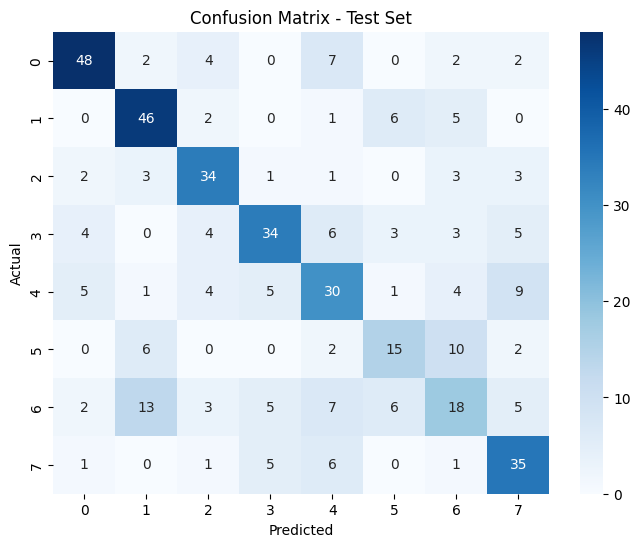

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Custom Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        self.labels = []
        
        for label, emotion in enumerate(sorted(os.listdir(image_folder))):
            emotion_folder = os.path.join(image_folder, emotion)
            if os.path.isdir(emotion_folder):
                for file in os.listdir(emotion_folder):
                    if file.endswith((".png", ".jpg", ".jpeg")):
                        self.image_files.append(os.path.join(emotion_folder, file))
                        self.labels.append(label)
        
        if not self.image_files:
            raise ValueError("No images found in the dataset directory.")
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, shear=15, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Corrected Model Function
def create_model(num_classes):
    model = models.vgg19_bn(weights=models.VGG19_BN_Weights.DEFAULT)
    
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze feature extractor
    
    num_ftrs = model.classifier[0].in_features  # Corrected input size: 25088
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),  # Corrected input feature size
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    best_val_acc = 0
    training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss, train_preds, train_labels = 0.0, [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step()
        
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_vgg19_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
    return model, training_history

# Model Evaluation (Test Set)
def evaluate_model(model, test_loader, device, num_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nFinal Model Evaluation on Test Set:")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(num_classes), 
                yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

# Main Function
def main():
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_folder_path = '/kaggle/input/emovox-1'
    full_dataset = EmotionDataset(image_folder_path, transform=train_transform)
    
    # Split dataset: 70% train, 15% validation, 15% test
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
    
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    num_classes = len(os.listdir(image_folder_path))
    model = create_model(num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    
    trained_model, _ = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)
    evaluate_model(trained_model, test_loader, device, num_classes)

if __name__ == "__main__":
    main()


# **Resnet_18**

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Epoch [1/50] Train Loss: 2.2771 Train Acc: 0.1226 Val Loss: 2.0656 Val Acc: 0.1434
Epoch [2/50] Train Loss: 2.1496 Train Acc: 0.1672 Val Loss: 1.9862 Val Acc: 0.1908
Epoch [3/50] Train Loss: 2.0798 Train Acc: 0.1881 Val Loss: 1.9089 Val Acc: 0.2509
Epoch [4/50] Train Loss: 2.0025 Train Acc: 0.2313 Val Loss: 1.8484 Val Acc: 0.3006
Epoch [5/50] Train Loss: 1.9202 Train Acc: 0.2610 Val Loss: 1.7811 Val Acc: 0.3503
Epoch [6/50] Train Loss: 1.8811 Train Acc: 0.2878 Val Loss: 1.7291 Val Acc: 0.3769
Epoch [7/50] Train Loss: 1.8111 Train Acc: 0.3221 Val Loss: 1.6769 Val Acc: 0.4150
Epoch [8/50] Train Loss: 1.7942 Train Acc: 0.3270 Val Loss: 1.6328 Val Acc: 0.4393
Epoch [9/50] Train Loss: 1.7192 Train Acc: 0.3653 Val Loss: 1.5969 Val Acc: 0.4486
Epoch [10/50] Train Loss: 1.6397 Train Acc: 0.4005 Val Loss: 1.5597 Val Acc: 0.4601
Epoch [11/50] Train Loss: 1.5849 Train Acc: 0.4228 Val Loss: 1.5062 Val Acc: 0.4879
Epoch [12/50] Train Loss: 1.5650 Train Acc: 0.4283 Val Loss: 1.4943 Val Acc: 0.5006
E

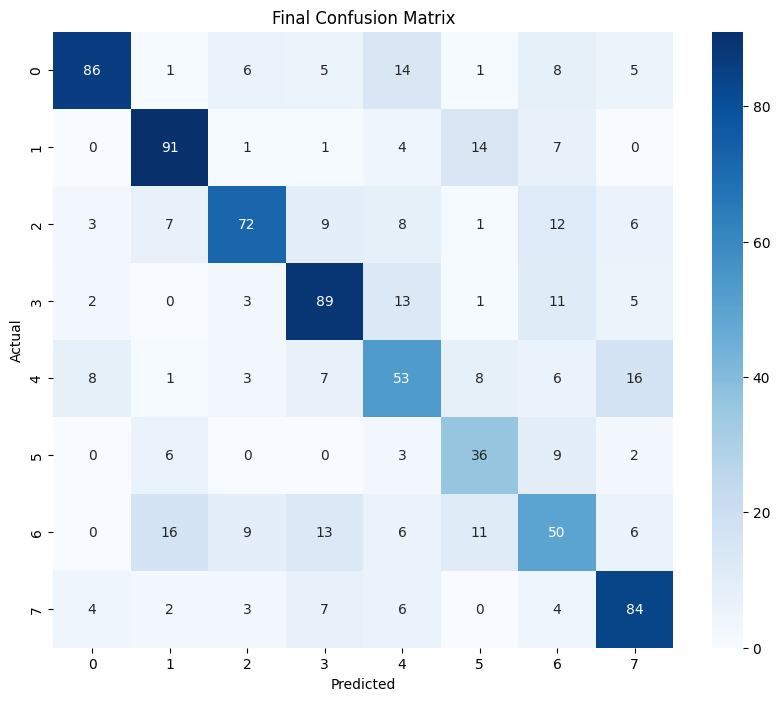

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EmotionDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        self.labels = []
        
        for label, emotion in enumerate(sorted(os.listdir(image_folder))):
            emotion_folder = os.path.join(image_folder, emotion)
            if os.path.isdir(emotion_folder):
                for file in os.listdir(emotion_folder):
                    if file.endswith((".png", ".jpg", ".jpeg")):
                        self.image_files.append(os.path.join(emotion_folder, file))
                        self.labels.append(label)
        
        if not self.image_files:
            raise ValueError("No images found in the dataset directory.")
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Updated create_model() function for ResNet18**
def create_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last residual block
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Modify the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    early_stopping = EarlyStopping(patience=7, min_delta=0.01)
    best_val_acc = 0
    best_epoch = 0
    training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
    return model, training_history

def evaluate_model(model, val_loader, device, num_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nFinal Model Evaluation:")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix')
    plt.show()

def main():
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_folder_path = '/kaggle/input/emovox-1'
    full_dataset = EmotionDataset(image_folder_path, transform=train_transform)
    
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    model = create_model(len(os.listdir(image_folder_path))).to(device)
    
    trained_model, _ = train_model(model, train_loader, val_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.00001), ReduceLROnPlateau(optim.Adam(model.parameters())), device)
    evaluate_model(trained_model, val_loader, device, len(os.listdir(image_folder_path)))

if __name__ == "__main__":
    main()


# **Eff_net_b3**

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


Epoch [1/50] Train Loss: 2.2785 Train Acc: 0.1211 Val Loss: 2.1164 Val Acc: 0.1387
Epoch [2/50] Train Loss: 2.1948 Train Acc: 0.1563 Val Loss: 2.0384 Val Acc: 0.1792
Epoch [3/50] Train Loss: 2.1664 Train Acc: 0.1583 Val Loss: 2.0032 Val Acc: 0.2162
Epoch [4/50] Train Loss: 2.1092 Train Acc: 0.1846 Val Loss: 1.9492 Val Acc: 0.2243
Epoch [5/50] Train Loss: 2.0677 Train Acc: 0.2050 Val Loss: 1.9151 Val Acc: 0.2497
Epoch [6/50] Train Loss: 2.0124 Train Acc: 0.2273 Val Loss: 1.8830 Val Acc: 0.2682
Epoch [7/50] Train Loss: 2.0065 Train Acc: 0.2357 Val Loss: 1.8606 Val Acc: 0.2821
Epoch [8/50] Train Loss: 1.9864 Train Acc: 0.2298 Val Loss: 1.8362 Val Acc: 0.2879
Epoch [9/50] Train Loss: 1.9332 Train Acc: 0.2715 Val Loss: 1.8089 Val Acc: 0.3075
Epoch [10/50] Train Loss: 1.9298 Train Acc: 0.2640 Val Loss: 1.8031 Val Acc: 0.2994
Epoch [11/50] Train Loss: 1.9412 Train Acc: 0.2700 Val Loss: 1.7797 Val Acc: 0.3237
Epoch [12/50] Train Loss: 1.8969 Train Acc: 0.2859 Val Loss: 1.7557 Val Acc: 0.3376
E

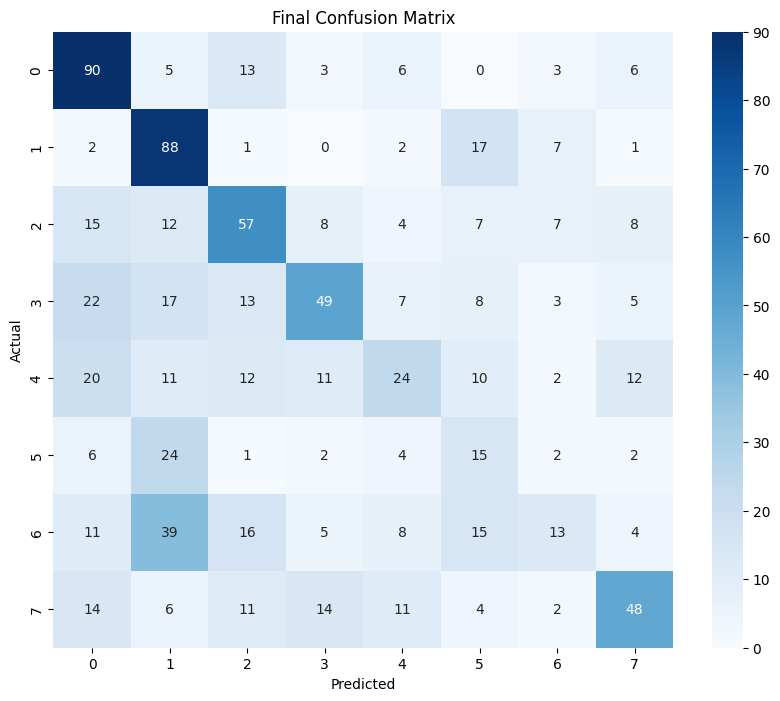

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EmotionDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        self.labels = []
        
        for label, emotion in enumerate(sorted(os.listdir(image_folder))):
            emotion_folder = os.path.join(image_folder, emotion)
            if os.path.isdir(emotion_folder):
                for file in os.listdir(emotion_folder):
                    if file.endswith((".png", ".jpg", ".jpeg")):
                        self.image_files.append(os.path.join(emotion_folder, file))
                        self.labels.append(label)
        
        if not self.image_files:
            raise ValueError("No images found in the dataset directory.")
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Updated create_model() function for EfficientNet-B0**
def create_model(num_classes):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    
    # Freeze feature extractor layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify the classifier (fully connected layers)
    num_ftrs = model.classifier[1].in_features  # EfficientNet's last FC layer input
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    early_stopping = EarlyStopping(patience=7, min_delta=0.01)
    best_val_acc = 0
    best_epoch = 0
    training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
    return model, training_history

def evaluate_model(model, val_loader, device, num_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nFinal Model Evaluation:")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix')
    plt.show()

def main():
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_folder_path = '/kaggle/input/emovox-1'
    full_dataset = EmotionDataset(image_folder_path, transform=train_transform)
    
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    model = create_model(len(os.listdir(image_folder_path))).to(device)
    
    trained_model, _ = train_model(model, train_loader, val_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.00001), ReduceLROnPlateau(optim.Adam(model.parameters())), device)
    evaluate_model(trained_model, val_loader, device, len(os.listdir(image_folder_path)))

if __name__ == "__main__":
    main()


# **Resnet 50**

Epoch [1/50] Train Loss: 2.2491 Train Acc: 0.1355 Val Loss: 2.0564 Val Acc: 0.1931
Epoch [2/50] Train Loss: 2.1474 Train Acc: 0.1628 Val Loss: 2.0088 Val Acc: 0.2150
Epoch [3/50] Train Loss: 2.0988 Train Acc: 0.1801 Val Loss: 1.9713 Val Acc: 0.2301
Epoch [4/50] Train Loss: 2.0257 Train Acc: 0.2288 Val Loss: 1.9205 Val Acc: 0.2439
Epoch [5/50] Train Loss: 1.9817 Train Acc: 0.2323 Val Loss: 1.8795 Val Acc: 0.2601
Epoch [6/50] Train Loss: 1.9358 Train Acc: 0.2511 Val Loss: 1.8499 Val Acc: 0.3017
Epoch [7/50] Train Loss: 1.8546 Train Acc: 0.2948 Val Loss: 1.7922 Val Acc: 0.3295
Epoch [8/50] Train Loss: 1.8089 Train Acc: 0.3280 Val Loss: 1.7537 Val Acc: 0.3526
Epoch [9/50] Train Loss: 1.7811 Train Acc: 0.3340 Val Loss: 1.7181 Val Acc: 0.3676
Epoch [10/50] Train Loss: 1.6882 Train Acc: 0.3727 Val Loss: 1.6810 Val Acc: 0.3931
Epoch [11/50] Train Loss: 1.6592 Train Acc: 0.3921 Val Loss: 1.6409 Val Acc: 0.4092
Epoch [12/50] Train Loss: 1.5658 Train Acc: 0.4164 Val Loss: 1.6087 Val Acc: 0.4173
E

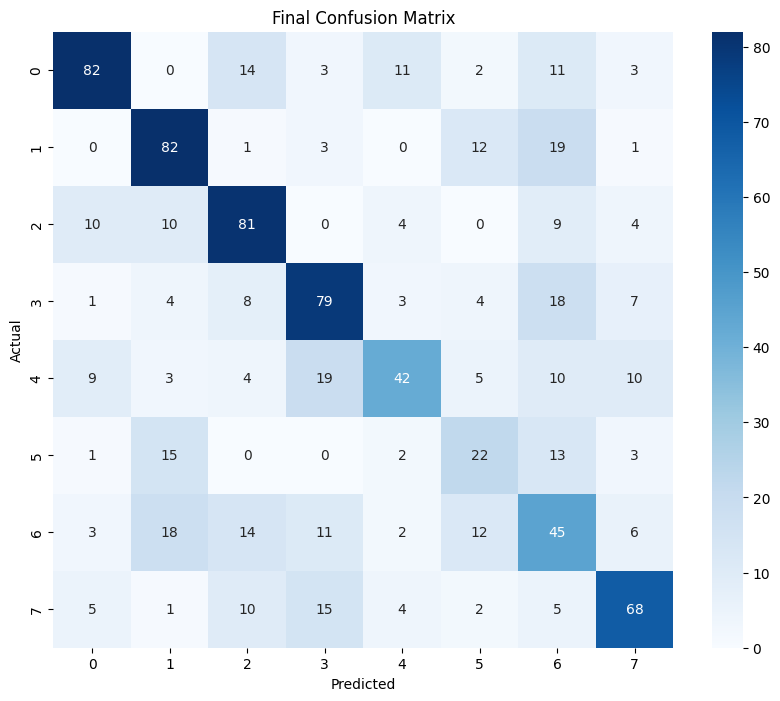

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EmotionDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        self.labels = []
        
        for label, emotion in enumerate(sorted(os.listdir(image_folder))):
            emotion_folder = os.path.join(image_folder, emotion)
            if os.path.isdir(emotion_folder):
                for file in os.listdir(emotion_folder):
                    if file.endswith((".png", ".jpg", ".jpeg")):
                        self.image_files.append(os.path.join(emotion_folder, file))
                        self.labels.append(label)
        
        if not self.image_files:
            raise ValueError("No images found in the dataset directory.")
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Updated create_model() function for ResNet-50**
def create_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last two residual blocks
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    # Modify the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    early_stopping = EarlyStopping(patience=7, min_delta=0.01)
    best_val_acc = 0
    best_epoch = 0
    training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
    return model, training_history

def evaluate_model(model, val_loader, device, num_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nFinal Model Evaluation:")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix')
    plt.show()

def main():
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_folder_path = '/kaggle/input/emovox-1'
    full_dataset = EmotionDataset(image_folder_path, transform=train_transform)
    
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    model = create_model(len(os.listdir(image_folder_path))).to(device)
    
    trained_model, _ = train_model(model, train_loader, val_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.00001), ReduceLROnPlateau(optim.Adam(model.parameters())), device)
    evaluate_model(trained_model, val_loader, device, len(os.listdir(image_folder_path)))

if __name__ == "__main__":
    main()


# **Alex_net**

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 215MB/s] 


Epoch [1/50] Train Loss: 2.0624 Train Acc: 0.2293 Val Loss: 1.7364 Val Acc: 0.3618
Epoch [2/50] Train Loss: 1.7169 Train Acc: 0.3772 Val Loss: 1.6018 Val Acc: 0.4162
Epoch [3/50] Train Loss: 1.5423 Train Acc: 0.4318 Val Loss: 1.4683 Val Acc: 0.4821
Epoch [4/50] Train Loss: 1.3871 Train Acc: 0.5007 Val Loss: 1.4020 Val Acc: 0.5075
Epoch [5/50] Train Loss: 1.2712 Train Acc: 0.5583 Val Loss: 1.3267 Val Acc: 0.5445
Epoch [6/50] Train Loss: 1.1596 Train Acc: 0.6169 Val Loss: 1.3082 Val Acc: 0.5329
Epoch [7/50] Train Loss: 1.0930 Train Acc: 0.6278 Val Loss: 1.2911 Val Acc: 0.5630
Epoch [8/50] Train Loss: 1.0467 Train Acc: 0.6481 Val Loss: 1.2407 Val Acc: 0.5642
Epoch [9/50] Train Loss: 0.9902 Train Acc: 0.6759 Val Loss: 1.2250 Val Acc: 0.5792
Epoch [10/50] Train Loss: 0.9223 Train Acc: 0.7206 Val Loss: 1.2230 Val Acc: 0.5838
Epoch [11/50] Train Loss: 0.8789 Train Acc: 0.7424 Val Loss: 1.1879 Val Acc: 0.5977
Epoch [12/50] Train Loss: 0.8231 Train Acc: 0.7568 Val Loss: 1.1894 Val Acc: 0.5896
E

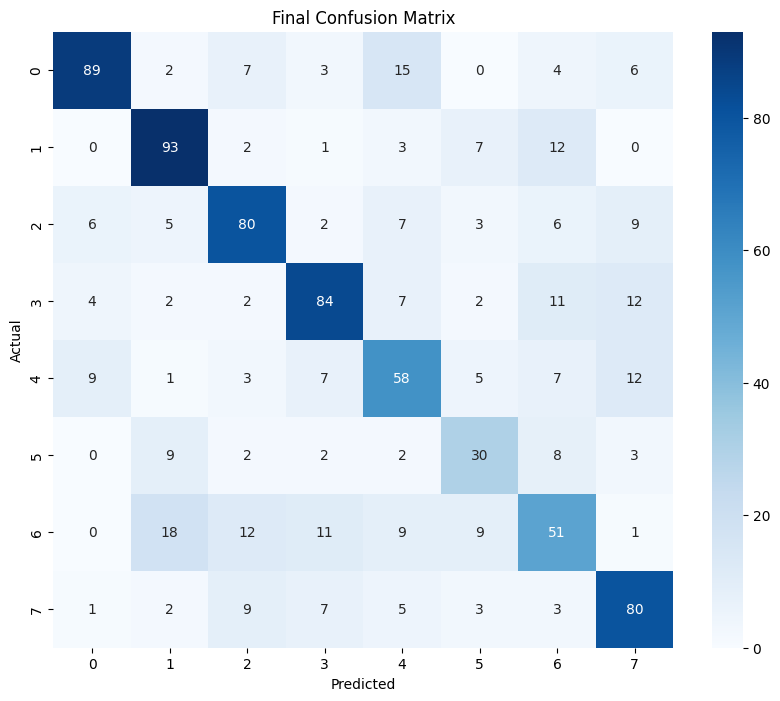

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EmotionDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = []
        self.labels = []
        
        for label, emotion in enumerate(sorted(os.listdir(image_folder))):
            emotion_folder = os.path.join(image_folder, emotion)
            if os.path.isdir(emotion_folder):
                for file in os.listdir(emotion_folder):
                    if file.endswith((".png", ".jpg", ".jpeg")):
                        self.image_files.append(os.path.join(emotion_folder, file))
                        self.labels.append(label)
        
        if not self.image_files:
            raise ValueError("No images found in the dataset directory.")
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **Updated create_model() function for AlexNet**
def create_model(num_classes):
    model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    
    # Freeze feature extractor layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Modify the classifier (fully connected layers)
    num_ftrs = model.classifier[1].in_features  # Corrected input size: 9216
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_ftrs, 512),  # Now correctly accepts 9216 features
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
    early_stopping = EarlyStopping(patience=7, min_delta=0.01)
    best_val_acc = 0
    best_epoch = 0
    training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss, val_preds, val_labels = 0.0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
        
    return model, training_history

def evaluate_model(model, val_loader, device, num_classes):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print("\nFinal Model Evaluation:")
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Final Confusion Matrix')
    plt.show()

def main():
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    image_folder_path = '/kaggle/input/emovox-1'
    full_dataset = EmotionDataset(image_folder_path, transform=train_transform)
    
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    val_dataset.dataset.transform = val_transform
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    model = create_model(len(os.listdir(image_folder_path))).to(device)
    
    trained_model, _ = train_model(model, train_loader, val_loader, nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.00001), ReduceLROnPlateau(optim.Adam(model.parameters())), device)
    evaluate_model(trained_model, val_loader, device, len(os.listdir(image_folder_path)))

if __name__ == "__main__":
    main()
